In [1]:
# Import data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Load Data

In [3]:
tracking = pd.read_csv('week1.csv')
players = pd.read_csv('players.csv')

tracking = tracking.merge(players, on='nflId')

In [4]:
tracking.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,...,dis,o,dir,event,height,weight,birthDate,collegeName,officialPosition,displayName
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,...,0.03,165.16,84.99,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,...,0.02,164.33,92.87,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,...,0.01,160.24,68.55,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,...,0.06,152.13,296.85,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,...,0.04,148.33,287.55,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady


# Process Data

In [5]:
# Get offense and defense teams based on which team has the Center
center_teams = tracking.groupby(['playId', 'officialPosition']).agg({'team': 'first'}).reset_index().query('officialPosition == "C"')[['playId', 'team']]

defense_teams = tracking.groupby(['playId', 'team']).agg({'officialPosition': 'first'}).reset_index()[['playId', 'team']]
defense_teams = defense_teams.merge(center_teams.drop_duplicates(), on=['playId','playId'], how='left')
defense_teams['isDefense'] = defense_teams.apply(lambda x: 1 if x['team_x'] != x['team_y'] else 0, axis=1)
defense_teams = defense_teams[defense_teams['isDefense'] == 1][['playId', 'team_x']]
defense_teams.columns = ['playId', 'team']


offense = tracking.merge(center_teams, on=['playId', 'team'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').query('event == "ball_snap"')
defense = tracking.merge(defense_teams, on=['playId', 'team'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').query('event == "ball_snap"')


# Create dataframe for each play
playIds = offense.playId.unique()

rel_tracking = pd.DataFrame()

for playId in playIds:
    
    play_df = offense.query('playId == @playId')[['playId', 'playDirection', 'officialPosition', 'x', 'y']]
    
    # Adjust postion relative to center
    center_record = play_df.query('officialPosition == "C"').iloc[0]

    C_x, C_y = center_record['x'], center_record['y']

    if play_df['playDirection'].iloc[0] == 'left':
        play_df['rel_x'] = C_x -play_df['x']
        play_df['rel_y'] = play_df['y'] - C_y
    else:
        play_df['rel_x'] = play_df['x'] - C_x
        play_df['rel_y'] = C_y - play_df['y']
        
    play_df = play_df[['playId', 'officialPosition', 'rel_x', 'rel_y']]
    
    # Sort by position and relative y to ensure consistent order
    play_df = play_df.sort_values(by=['officialPosition', 'rel_y'])[['officialPosition', 'rel_x', 'rel_y']]
    
    positions = play_df['officialPosition'].values
    
    # switch x and y
    xs = play_df['rel_y'].values
    ys = play_df['rel_x'].values
    personnel = ' '.join(positions)

    transformed_data = {
        'location': np.concatenate((xs, ys))
    }

    transformed_df = pd.DataFrame(transformed_data).T
    transformed_df['personnel'] = [personnel]
    transformed_df.columns = [f'x_{i}' for i in range(1, 12)] + [f'y_{i}' for i in range(1, 12)] + ['personnel']
    transformed_df = transformed_df.reset_index(drop=True)
    
    rel_tracking = pd.concat((rel_tracking, transformed_df))
    
rel_tracking

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,personnel
0,0.0,-1.63,1.39,-0.24,1.75,-2.90,2.71,-5.32,-12.75,-11.07,...,-0.69,-4.46,-4.55,-0.72,-0.99,-0.45,-1.06,-1.94,-0.09,C G G QB RB T T TE WR WR WR
0,0.0,-1.65,1.37,-0.20,-18.27,-2.88,2.70,4.34,-9.19,8.61,...,-0.83,-4.13,-0.95,-0.77,-1.23,-0.14,-0.14,-1.76,-1.11,C G G QB RB T T TE WR WR WR
0,0.0,-1.68,1.69,-0.25,-2.26,-3.06,2.64,4.73,-17.28,8.79,...,-0.71,-4.16,-4.12,-0.92,-1.00,-0.11,-0.33,-1.92,-0.62,C G G QB RB T T TE WR WR WR
0,0.0,-1.64,1.48,-0.26,2.55,-3.20,2.80,4.64,-17.81,9.57,...,-0.82,-4.19,-4.01,-0.97,-1.10,-0.32,-0.39,-1.44,-1.48,C G G QB RB T T TE WR WR WR
0,0.0,-1.58,1.45,-0.09,-2.30,-3.01,2.81,4.50,-15.02,11.41,...,-0.74,-4.15,-4.41,-0.79,-0.94,-0.47,-0.43,-1.48,-0.90,C G G QB RB T T TE WR WR WR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,-1.60,1.43,0.01,2.44,-3.03,2.94,-7.40,-18.26,-12.48,...,-0.28,-4.82,-5.64,-1.16,-0.96,-0.37,-0.81,-1.16,-0.59,C G G QB RB T T TE WR WR WR
0,0.0,5.47,-1.33,1.57,0.12,-0.08,-2.79,3.32,-5.99,-4.39,...,-0.85,-0.86,-5.15,-7.40,-1.02,-1.04,-0.94,-0.88,-0.33,C FB G G QB RB T T TE TE WR
0,0.0,-1.25,1.64,0.10,-3.00,2.99,8.82,-18.12,-12.29,-7.65,...,-0.60,-4.62,-1.16,-0.91,-0.09,-1.04,-0.60,-0.13,-0.92,C G G QB T T TE WR WR WR WR
0,0.0,-1.38,1.58,0.07,2.39,-2.87,2.77,6.35,-16.68,-10.32,...,-0.48,-4.93,-4.95,-0.91,-0.68,-0.30,-0.15,-1.10,-1.47,C G G QB RB T T TE WR WR WR


In [6]:
# Get personnel groups
rel_tracking['personnel'].value_counts()

personnel
C G G QB RB T T TE WR WR WR    508
C G G QB RB T T TE TE WR WR    159
C FB G G QB RB T T TE WR WR     49
C G QB RB T T T TE WR WR WR     45
C G G QB RB T T WR WR WR WR     35
C G G G QB RB T TE WR WR WR     33
C G G QB RB T T TE TE TE WR     24
C C G QB RB T T TE WR WR WR     16
C G QB RB T T T TE TE WR WR      8
C C G QB RB T T TE TE WR WR      7
C G G QB RB RB T T TE TE WR      7
C G G QB T T WR WR WR WR WR      7
C G G QB RB RB T T TE WR WR      6
C FB G QB RB T T T WR WR WR      6
C FB G G QB RB T T TE TE WR      5
C G G QB T T TE WR WR WR WR      4
C G QB T T T TE WR WR WR WR      4
C G QB RB T T T WR WR WR WR      4
C G QB RB T T T TE TE TE WR      4
C G G QB T T TE TE WR WR WR      3
C FB G G QB RB T T WR WR WR      3
C G QB RB RB T T T TE WR WR      3
C C FB G QB RB T T TE WR WR      2
C C QB RB T T T TE WR WR WR      2
C FB G QB RB T T T TE WR WR      2
C G G G QB RB T WR WR WR WR      1
C G G G QB RB T TE TE WR WR      1
C FB G G G QB RB T T TE TE       1
C G G QB R

# Plot All Formations

Text(0.5, 1.0, 'All Offensive Formations')

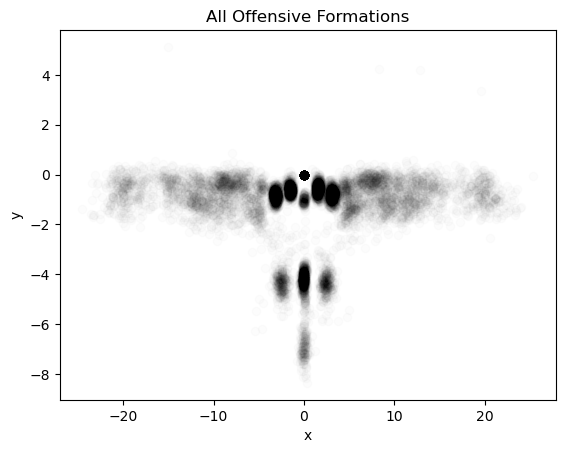

In [214]:
xs = rel_tracking[[col for col in rel_tracking.columns if col.startswith('x')]].values
ys = rel_tracking[[col for col in rel_tracking.columns if col.startswith('y')]].values

plt.plot(xs, ys, 'ok', alpha=0.01)
plt.xlabel('x')
plt.ylabel('y')
plt.title('All Offensive Formations')

# Select Personnel Group

In [223]:
specific_personnel_tracking = rel_tracking.query('personnel == "C G G QB RB T T TE WR WR WR"')
specific_personnel_tracking

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,personnel
0,0.0,-1.63,1.39,-0.24,1.75,-2.90,2.71,-5.32,-12.75,-11.07,...,-0.69,-4.46,-4.55,-0.72,-0.99,-0.45,-1.06,-1.94,-0.09,C G G QB RB T T TE WR WR WR
0,0.0,-1.65,1.37,-0.20,-18.27,-2.88,2.70,4.34,-9.19,8.61,...,-0.83,-4.13,-0.95,-0.77,-1.23,-0.14,-0.14,-1.76,-1.11,C G G QB RB T T TE WR WR WR
0,0.0,-1.68,1.69,-0.25,-2.26,-3.06,2.64,4.73,-17.28,8.79,...,-0.71,-4.16,-4.12,-0.92,-1.00,-0.11,-0.33,-1.92,-0.62,C G G QB RB T T TE WR WR WR
0,0.0,-1.64,1.48,-0.26,2.55,-3.20,2.80,4.64,-17.81,9.57,...,-0.82,-4.19,-4.01,-0.97,-1.10,-0.32,-0.39,-1.44,-1.48,C G G QB RB T T TE WR WR WR
0,0.0,-1.58,1.45,-0.09,-2.30,-3.01,2.81,4.50,-15.02,11.41,...,-0.74,-4.15,-4.41,-0.79,-0.94,-0.47,-0.43,-1.48,-0.90,C G G QB RB T T TE WR WR WR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,-1.41,1.42,0.22,2.13,-2.78,2.94,11.32,-14.16,-9.28,...,-0.69,-4.83,-5.13,-0.97,-0.93,-0.09,-1.06,-0.03,-1.87,C G G QB RB T T TE WR WR WR
0,0.0,-1.02,1.66,0.18,2.39,-2.89,3.43,7.33,-15.12,-8.55,...,-0.43,-4.97,-4.93,-0.86,-0.70,-0.11,-0.63,-0.77,-1.08,C G G QB RB T T TE WR WR WR
0,0.0,-1.60,1.43,0.01,2.44,-3.03,2.94,-7.40,-18.26,-12.48,...,-0.28,-4.82,-5.64,-1.16,-0.96,-0.37,-0.81,-1.16,-0.59,C G G QB RB T T TE WR WR WR
0,0.0,-1.38,1.58,0.07,2.39,-2.87,2.77,6.35,-16.68,-10.32,...,-0.48,-4.93,-4.95,-0.91,-0.68,-0.30,-0.15,-1.10,-1.47,C G G QB RB T T TE WR WR WR


# K-means

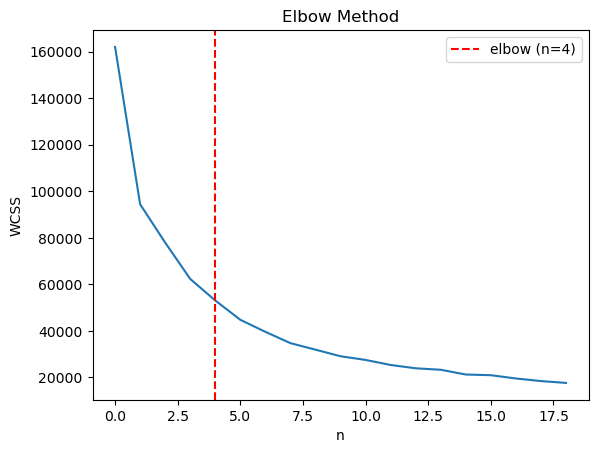

In [224]:
wcss = []

for n in range(1, 20):
    km = KMeans(n_clusters=n, n_init=10, max_iter=300)
    km.fit(specific_personnel_tracking.drop('personnel', axis=1))
    wcss.append(km.inertia_)
    
plt.plot(wcss)
plt.axvline(4, color='r',linestyle='--', label='elbow (n=4)')
plt.xlabel('n')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.legend()
plt.show()

km = KMeans(n_clusters=4, n_init=3, max_iter=300)
km.fit(specific_personnel_tracking.drop('personnel', axis=1))

predictions = km.predict(specific_personnel_tracking.drop('personnel', axis=1))



# DBSCAN

In [98]:
db = DBSCAN(eps=2.5, min_samples=3)
db.fit(specific_personnel_tracking.drop('personnel', axis=1))

DBSCAN(eps=2.5, min_samples=3)

# Plot results

In [129]:
def squish(x):
    if x > 0:
        return x
    return max(x**7, x)

In [201]:
def plot_cluster(df, model, label, ax):
    
    # Get resulting df
    result = df.iloc[np.where(model.labels_ == label)]

    xs = result[[col for col in result.columns if col.startswith('x')]].values
    ys = result[[col for col in result.columns if col.startswith('y')]].values
    positions = result['personnel'].values[0].split(' ')

    for i in range(0, len(xs[0])):
        px = xs[:, i]
        
        # sqush ys closer to 0
        py = [squish(y) for y in ys[:, i]]
        ax.plot(px, py, 'o', alpha=0.1, color=(83/255, 173/255, 230/255))
        
        mean_x = np.mean(px)
        mean_y = min(-0.3, np.mean(py))
        
        ax.text(mean_x, mean_y, positions[i], color='w', fontsize='medium')
        
    ax.set_xlim(-26.75, 26.75)
    ax.set_ylim(-5, 1)
    ax.set_facecolor((27/255, 107/255, 19/255))
    ax.axhline(0, color='w', alpha=0.2)
    ax.axhline(-5, color='w', alpha=0.7)
    
    # Plot hask marks
    ax.plot([-6.1-0.5, -6.1+0.5], [-1, -1], '-', color='w', alpha=0.3)
    ax.plot([-6.1-0.5, -6.1+0.5], [-2, -2], '-', color='w', alpha=0.3)
    ax.plot([-6.1-0.5, -6.1+0.5], [-3, -3], '-', color='w', alpha=0.3)
    ax.plot([-6.1-0.5, -6.1+0.5], [-4, -4], '-', color='w', alpha=0.3)
    ax.plot([-6.1-0.5, -6.1+0.5], [-5, -5], '-', color='w', alpha=0.3)
    
    ax.plot([6.1-0.5, 6.1+0.5], [-1, -1], '-', color='w', alpha=0.3)
    ax.plot([6.1-0.5, 6.1+0.5], [-2, -2], '-', color='w', alpha=0.3)
    ax.plot([6.1-0.5, 6.1+0.5], [-3, -3], '-', color='w', alpha=0.3)
    ax.plot([6.1-0.5, 6.1+0.5], [-4, -4], '-', color='w', alpha=0.3)
    ax.plot([6.1-0.5, 6.1+0.5], [-5, -5], '-', color='w', alpha=0.3)

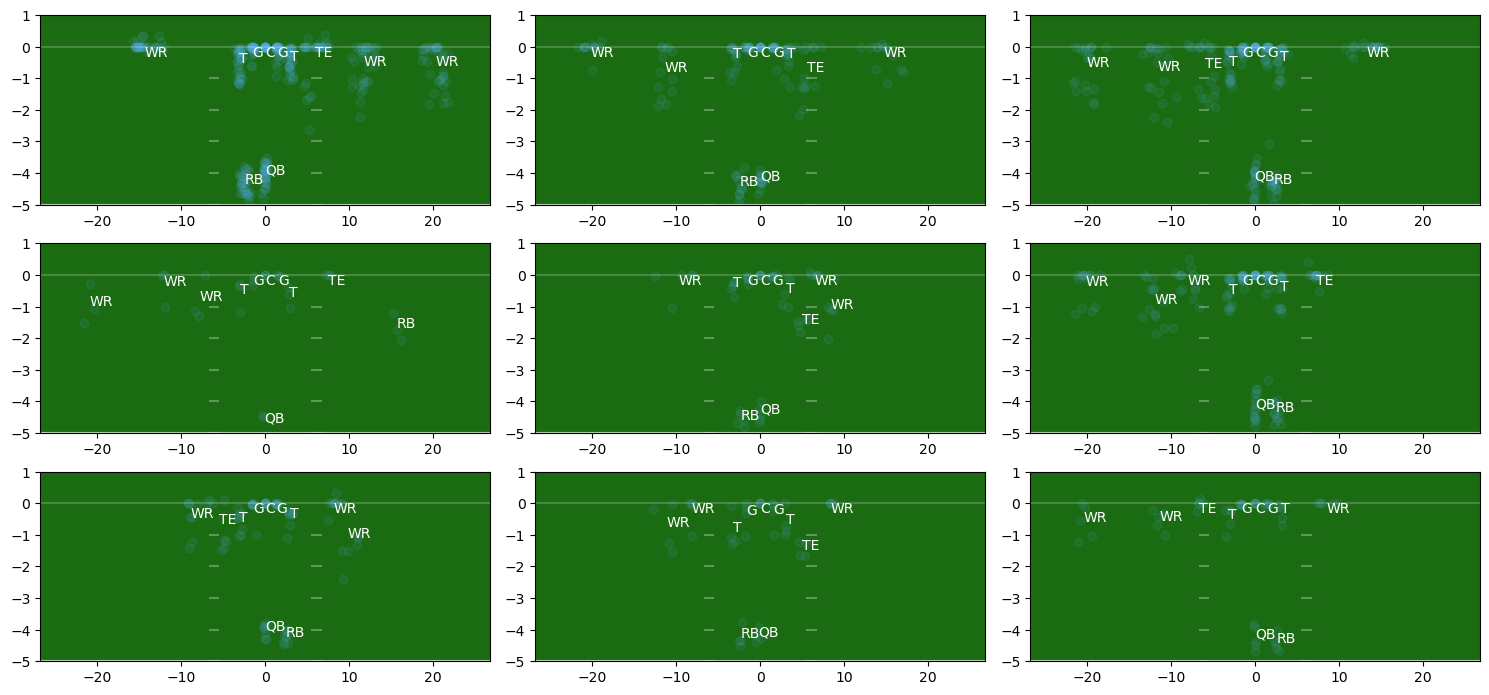

In [227]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 7))

model = db

for i, label in enumerate([x for x in np.unique(model.labels_) if x >= 0][:9]):
    
    row = i // 3
    col = i % 3
    
    plot_cluster(specific_personnel_tracking, model, label, axs[row, col])
    
plt.tight_layout()
plt.show()